In [1]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Subset

from torchvision import transforms, datasets 
from ptflops import get_model_complexity_info
from torchmetrics.classification import MulticlassAccuracy, BinaryAccuracy
from torchmetrics import ConfusionMatrix
from utils.Trainer import ModelTrainer

import copy

C:\Users\gmald\anaconda3\envs\genml\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def train_test_model(model, lr, trainLoader, validateLoader, testLoader, EPOCHS, noPrint=False):
    Trainer = ModelTrainer(model, nn.CrossEntropyLoss(), torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9), MulticlassAccuracy, "Classification",  config.device, 10, noPrint=noPrint)
    t0 = datetime.now()
    Trainer.fit(trainLoader, validateLoader, EPOCHS)
    t1 = datetime.now()
    Trainer.Test_Model(testLoader)
    
    macs, params = get_model_complexity_info(Trainer.model, (3, 64, 64), as_strings=True, print_per_layer_stat=False, verbose=True)
    
    
    print("Time to Train:", t1 - t0)
    if not noPrint:
        print("\nTest Accuracy:", Trainer.Metrics["Test Accuracy"])
        print(f"Macs:{macs} | Params:{params}")
        Trainer.Graph_Metrics()
        
    Trainer.model.to("cpu")
    
    return Trainer, (macs, params)

In [3]:
# A class build to hold all configurations to train the model
class Configuration:
    def __init__(self, root, EPOCHS, LR, imageSize, batchSize):
        self.root = root
        
        self.EPOCHS = EPOCHS
        self.lr = LR
        self.Is = (imageSize, imageSize)
        self.Bs = batchSize
        self.train_validate_percent = 0.90
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = Configuration(root="M:\Datasets", EPOCHS=30, LR=0.001, imageSize=64, batchSize=128)

In [4]:
transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=config.Is),
    transforms.Normalize((0.4734), (0.2111)),
])

cifar_trainset = datasets.CIFAR10(root=config.root, train=True, download=False, transform=transformation)
cifar_testset = datasets.CIFAR10(root=config.root, train=False, download=False, transform=transformation)

train_cifar, valid_cifar = random_split(cifar_trainset, [0.9, 0.1])
trainLoader = DataLoader(train_cifar, batch_size=config.Bs, num_workers=1, pin_memory=True, shuffle=True)
validLoader = DataLoader(valid_cifar, batch_size=config.Bs, num_workers=1, pin_memory=True, shuffle=False)
testLoader = DataLoader(cifar_testset, batch_size=config.Bs, num_workers=1, pin_memory=True, shuffle=False)

print(cifar_trainset, "\n")
print(cifar_testset)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: M:\Datasets
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               Normalize(mean=0.4734, std=0.2111)
           ) 

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: M:\Datasets
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               Normalize(mean=0.4734, std=0.2111)
           )


### Problem 1 (30pts)

In [5]:
def vgg_block(num_convs, out_channels, stride):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.LazyBatchNorm2d())
        layers.append(nn.ReLU())

    layers.append(nn.MaxPool2d(kernel_size=2, stride=stride))

    return nn.Sequential(*layers)

class VGG(nn.Module):
    def __init__(self, arch, num_class=10):
        super(VGG, self).__init__()
        conv_blks = []
        
        for num_convs, out_channels, stride in arch:
            conv_blks.append(vgg_block(num_convs, out_channels, stride))
            
        self.net = nn.Sequential(
            *conv_blks, 
            
            nn.Flatten(),
            nn.LazyLinear(2048), 
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.LazyLinear(1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.LazyLinear(num_class),
        )
        
    def forward(self, x):
        return self.net(x)

### Train the based line VGG model

Time to Train: 0:03:51.093310
VGG Model Test: 0.8164999485015869
VGG Model Train: 0.9604687094688416
Macs:620.29 MMac | Params:15.53 M


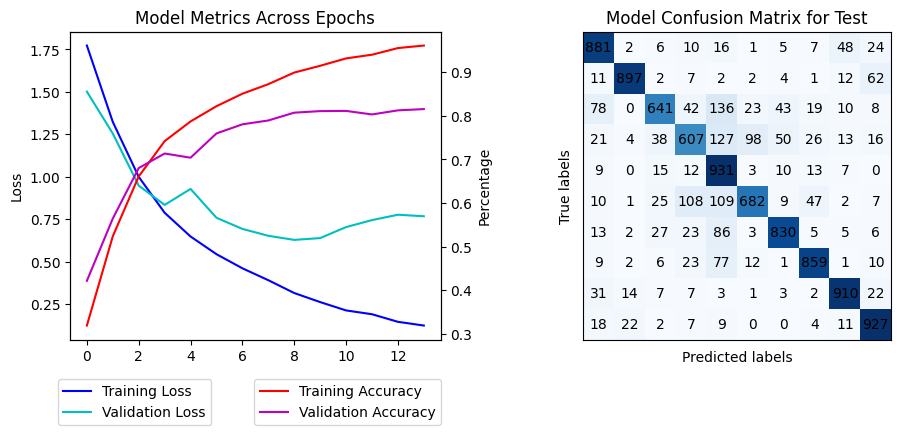

In [37]:
arch = [(1, 64, 2), (1, 128, 2), (2, 256, 2), (2, 512, 2), (2, 512, 2)]
vgg_net = VGG(arch)

VggTrainer, mp = train_test_model(vgg_net, config.lr*120, trainLoader, validLoader, testLoader, config.EPOCHS, noPrint=True)
print("VGG Model Test:", VggTrainer.Metrics["Test Accuracy"])
print("VGG Model Train:", VggTrainer.Metrics["Training Accuracy"][-1].item())
print(f"Macs:{mp[0]} | Params:{mp[1]}")
VggTrainer.Graph_Metrics()

### Use Table 1 in the VGG paper to construct VGG-19

Time to Train: 0:07:31.225505
VGG-19 Model Test: 0.8356999754905701
VGG-19 Model Train: 0.9442921280860901
Macs:1.6 GMac | Params:26.34 M


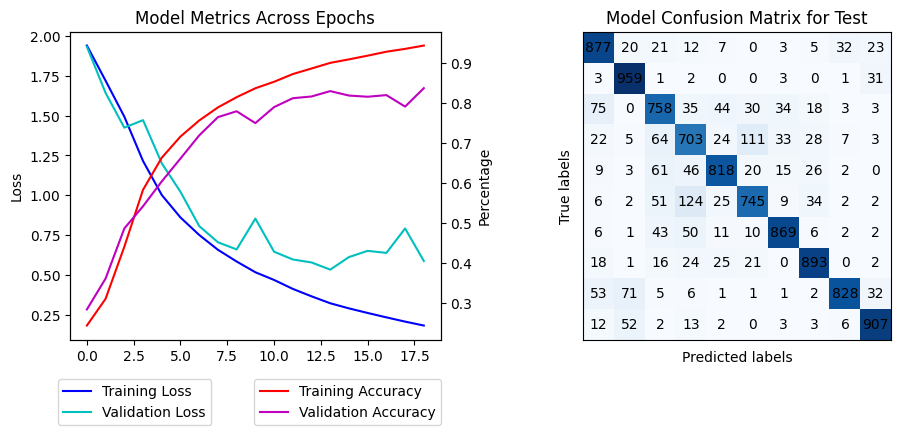

In [36]:
arch = [(2, 64, 2), (2, 128, 2), (4, 256, 2), (4, 512, 2), (4, 512, 2)]
vgg_net19 = VGG(arch)

Vgg19Trainer, mp = train_test_model(vgg_net19, config.lr*90, trainLoader, validLoader, testLoader, config.EPOCHS, noPrint=True)
print("VGG-19 Model Test:", Vgg19Trainer.Metrics["Test Accuracy"])
print("VGG-19 Model Train:", Vgg19Trainer.Metrics["Training Accuracy"][-1].item())
print(f"Macs:{mp[0]} | Params:{mp[1]}")
Vgg19Trainer.Graph_Metrics()

### VGG Baseline

Time to Train: 0:03:51.093310
    
Accuracy- Training: 0.96   Test: 0.81

Macs:620.29 MMac | Params:15.53 M

### VGG-19
    
Time to Train: 0:07:31.225505
    
Accuracy- Training: 0.94   Test: 0.84

Macs:1.6 GMac | Params:26.34 M    

### Results

VGG is a very simple network to design and work with. However it does run into some pitfalls in regards to its ablity to generalize to test data as in the graphs. However as it scales such as in VGG-19 it has a much better generalization to the test data. However VGG-19 requires a much larger amount of parameters and significant amount of more time for training. There is a about a 3% improvement shown here.

### Problem 2 (30pts)

In [8]:
   class Inception(nn.Module):
    def __init__(self, c1, c2, c3, c4, use_bn=False):
        super(Inception, self).__init__()
        
        self.b1 = nn.Sequential(
            nn.LazyConv2d(c1, kernel_size=1),
            nn.LazyBatchNorm2d() if use_bn else nn.Identity(),
            nn.ReLU(),
        )

        
        self.b2 = nn.Sequential(
            nn.LazyConv2d(c2[0], kernel_size=1),
            nn.LazyBatchNorm2d() if use_bn else nn.Identity(),
            nn.ReLU(),
            
            nn.LazyConv2d(c2[1], kernel_size=3, padding=1),
            nn.LazyBatchNorm2d() if use_bn else nn.Identity(),
            nn.ReLU(),
        )

        
        self.b3 = nn.Sequential(
            nn.LazyConv2d(c3[0], kernel_size=1),
            nn.LazyBatchNorm2d() if use_bn else nn.Identity(),
            nn.ReLU(),
            
            nn.LazyConv2d(c3[1], kernel_size=3, padding=1),
            nn.LazyBatchNorm2d() if use_bn else nn.Identity(),
            nn.ReLU(),
        )

        
        self.b4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.LazyConv2d(c4, kernel_size=1),
            nn.LazyBatchNorm2d() if use_bn else nn.Identity(),
            nn.ReLU(),
        )

    def forward(self, x):
        out0 = self.b1(x)
        out1 = self.b2(x)
        out2 = self.b3(x)
        out3 = self.b4(x)
        return torch.cat([out0,out1,out2,out3], 1)

In [9]:
class GoogLeNet(nn.Module):
    def __init__(self, use_bn=False):
        super(GoogLeNet, self).__init__()
        self.use_bn = use_bn
        
        self.stem = nn.Sequential(
            nn.LazyConv2d(64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            nn.LazyConv2d(64, kernel_size=1),
            nn.ReLU(),
            nn.LazyConv2d(192, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.body1 = nn.Sequential(
            Inception(192, (64, 96), (32, 64), 32, self.use_bn),
            Inception(256, (64, 96), (32, 64), 64, self.use_bn),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.body2 = nn.Sequential(
            Inception(320, (128, 160), (64, 96), 64, self.use_bn),
            Inception(640, (192, 256), (64, 128), 128, self.use_bn),
            nn.AdaptiveAvgPool2d((1,1)),
        )
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            
            nn.LazyLinear(512),
            nn.ReLU(),
            
            nn.Dropout1d(0.4),
            nn.LazyLinear(10)
        )
        
        self.net = nn.Sequential(
            self.stem,
            self.body1,
            self.body2,
            self.fc
        )
    
    def forward(self, x):
        return self.net(x)
        

### Train a baseline classifier based on the GoogLeNet model

Time to Train: 0:08:50.163627
GoogLe Model Test: 0.792199969291687
GoogLe Model Train: 0.557464063167572
Macs:660.48 MMac | Params:2.77 M


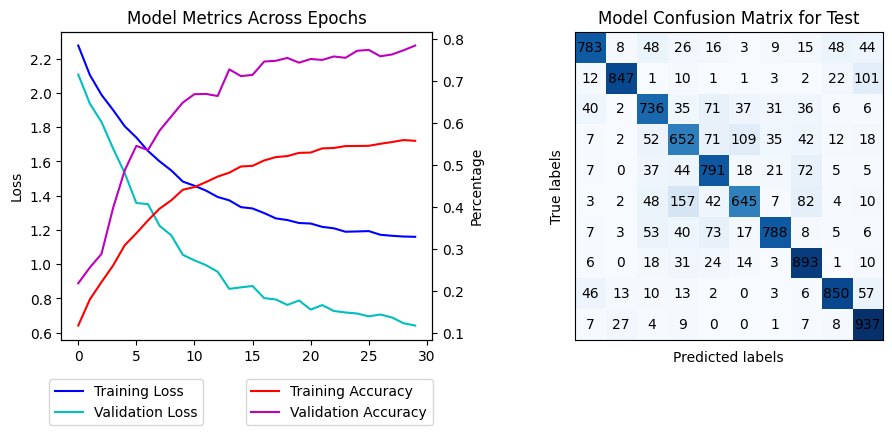

In [33]:
GoogLeModel = GoogLeNet()

GoogLeTrainer, mp = train_test_model(GoogLeModel, config.lr*100, trainLoader, validLoader, testLoader, config.EPOCHS, noPrint=True)
print("GoogLe Model Test:", GoogLeTrainer.Metrics["Test Accuracy"])
print("GoogLe Model Train:", GoogLeTrainer.Metrics["Training Accuracy"][-1].item())
print(f"Macs:{mp[0]} | Params:{mp[1]}")
GoogLeTrainer.Graph_Metrics()

### Add batch normalization layer to GoogLeNet
I decided to add batch norm to each convolution layer within the inception block while not including batch norm with the stem parts of the model structure. My conclusion on GoogLeNet is that it is horrible to implement and constantly finicky in terms of its learning rate and complexity. There is this strange balance between the complexity of the model and the increasing of the learning rate otherwise it will not train. I had to spend hours reducing the complexity of the model and have managed to have a model which underfits to its training data and does quite well on the validation data (How?? Im not sure). Not a very fun model to work with.

Time to Train: 0:08:02.106904
GoogLe Model w/ Batch Test: 0.8213000297546387
GoogLe Model w/ Batch Train: 0.616565465927124
Macs:662.13 MMac | Params:2.78 M


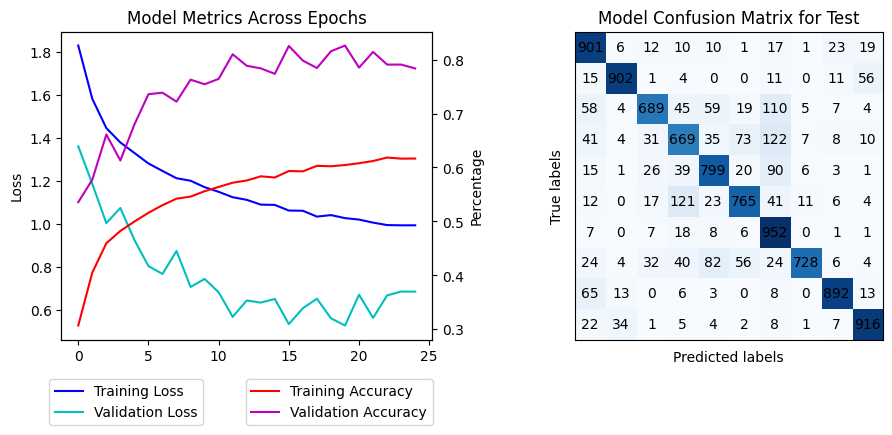

In [34]:
GoogLeModel_norm = GoogLeNet(use_bn=True)

GoogLeTrainer_norm, mp = train_test_model(GoogLeModel_norm, config.lr*30, trainLoader, validLoader, testLoader, config.EPOCHS, noPrint=True)
print("GoogLe Model w/ Batch Test:", GoogLeTrainer_norm.Metrics["Test Accuracy"])
print("GoogLe Model w/ Batch Train:", GoogLeTrainer_norm.Metrics["Training Accuracy"][-1].item())
print(f"Macs:{mp[0]} | Params:{mp[1]}")
GoogLeTrainer_norm.Graph_Metrics()

### GoogLeModel

Time to Train: 0:08:50.163627
    
Accuracy- Training: 0.55   Test: 0.79

Macs:662.13 MMac | Params:2.77 M

### GoogLeModel w/ Batch Norm
    
Time to Train: 0:09:13.569654
    
Accuracy- Training: 0.62   Test: 0.82

Macs:662.13 MMac | Params:2.78 M   

### Results

GoogLeNet has been a particularly difficult network to work with. The Inception block is quite complicated and difficult to manage requiring specific learning rates or else it will not train at all. However it has dramatically reduced Parameters and the same MMacs as VGG yet is still able to out-preform VGG-19. Compared the two googLeNets we have with and without Batch Norm. The model with batch Norm was able to improve accuracy by 3% while only slightly increase the time to train while not affecting the overall complexity of the model.

### Problem 3 (40pts)

In [12]:
class Residual(nn.Module):
    def __init__(self, num_channels, stride=1):
        super(Residual, self).__init__()
        self.num_channels = num_channels
        
        self.net = nn.Sequential(
            nn.LazyConv2d(num_channels, kernel_size=3, padding=1, stride=stride),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            
            
            nn.LazyConv2d(num_channels, kernel_size=3, padding=1, stride=stride),
            nn.LazyBatchNorm2d(),
        )
        
        self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=stride)
        self.finalRelu = nn.ReLU()
        
        
    def forward(self, x):
        
        out = self.net(x)
        
        if self.num_channels != x.shape[1]:
            x = self.conv3(x)
        else:
            self.conv3 = None
            
        out += x 
        
        return self.finalRelu(out)
        

In [13]:
class ResNet(nn.Module):
    def __init__(self, arch, num_classes=10):
        super(ResNet, self).__init__()
        
        self.stem = nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.body = nn.Sequential()
        
        for i, b in enumerate(arch):
            self.body.add_module(f'b{i+2}', self.res_block(*b))
            
        self.body.add_module('AV Pool', nn.AdaptiveAvgPool2d((1,1)))
            
        self.fc = nn.Sequential(
            nn.Flatten(),
            
            nn.LazyLinear(512),
            nn.Dropout(0.4),
            nn.ReLU(),
            
            nn.LazyLinear(num_classes),
        )
                            
        self.net = nn.Sequential(
            self.stem,
            self.body,
            self.fc,
        )
        
    def forward(self, x):
        x = self.stem(x)
        x = self.body(x)
        
        x = self.fc(x)
        
        return x
        
        
    def res_block(self, num_residuals, num_channels):
        
        blk = []
        
        for i in range(num_residuals):
            
            blk.append(Residual(num_channels))
           
        return nn.Sequential(*blk)

### Train ResNet-18 for CIFAR-10

Time to Train: 0:09:52.998188
ResNet18 Model Test: 0.8271000385284424
ResNet18 Model Train: 0.9296358227729797
Macs:5.74 GMac | Params:11.45 M


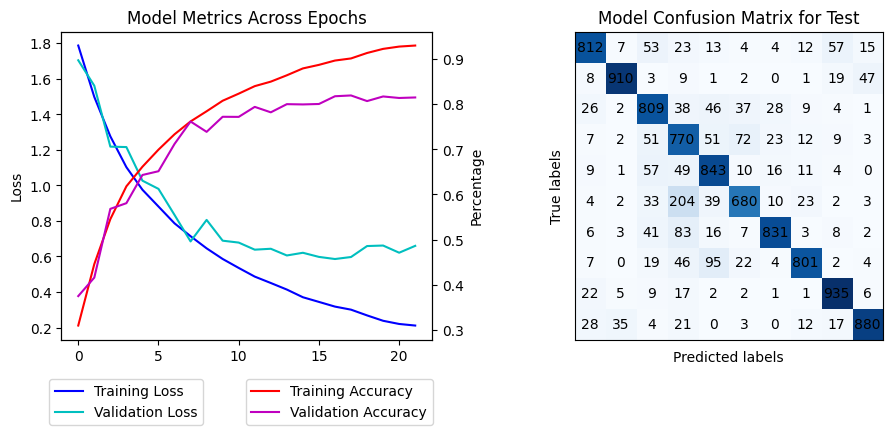

In [18]:
ResNet18 = ResNet( ((2, 64), (2, 128), (2, 256), (2, 512)) )

ResNet18Trainer, mp = train_test_model(ResNet18, config.lr*100, trainLoader, validLoader, testLoader, config.EPOCHS, noPrint=True)
print("ResNet18 Model Test:", ResNet18Trainer.Metrics["Test Accuracy"])
print("ResNet18 Model Train:", ResNet18Trainer.Metrics["Training Accuracy"][-1].item())
print(f"Macs:{mp[0]} | Params:{mp[1]}")
ResNet18Trainer.Graph_Metrics()

### Train ResNet-26 for CIFAR-10

Time to Train: 0:13:38.785628
ResNet26 Model Test: 0.810200035572052
ResNet26 Model Train: 0.9378430843353271
Macs:7.25 GMac | Params:14.4 M


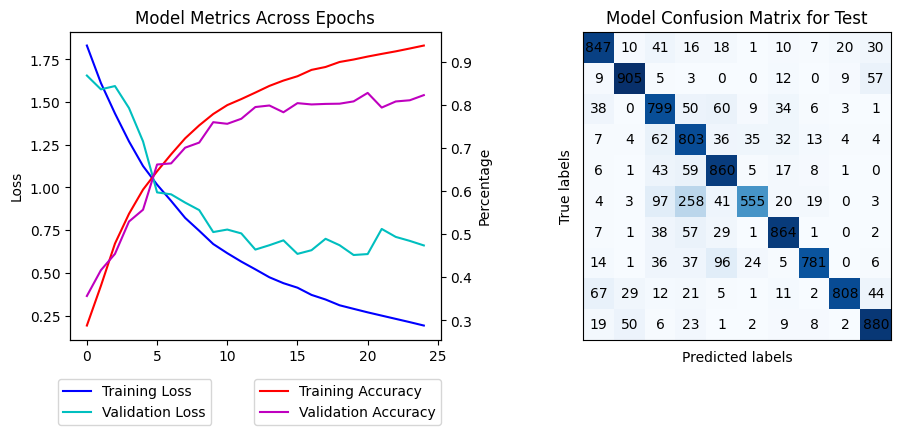

In [26]:
ResNet26 = ResNet( ((2, 64), (4, 128), (4, 256), (2, 512)) )

ResNet26Trainer, mp = train_test_model(ResNet26, config.lr*100, trainLoader, validLoader, testLoader, config.EPOCHS, noPrint=True)
print("ResNet26 Model Test:", ResNet26Trainer.Metrics["Test Accuracy"])
print("ResNet26 Model Train:", ResNet26Trainer.Metrics["Training Accuracy"][-1].item())
print(f"Macs:{mp[0]} | Params:{mp[1]}")
ResNet26Trainer.Graph_Metrics()

### Train ResNet-32 for CIFAR-10

Time to Train: 0:15:05.729488
ResNet32 Model Test: 0.8212000131607056
ResNet32 Model Train: 0.9261317849159241
Macs:10.43 GMac | Params:20.6 M


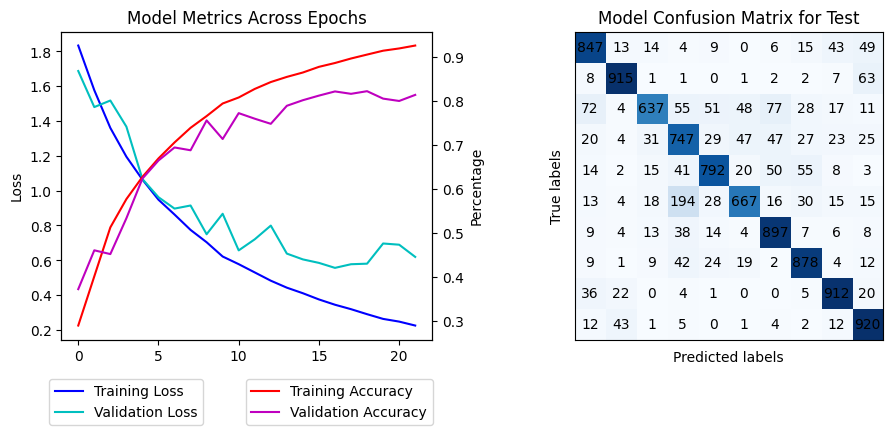

In [39]:
ResNet32 = ResNet( ((2, 64), (5, 128), (5, 256), (3, 512)) )

ResNet32Trainer, mp = train_test_model(ResNet32, config.lr*80, trainLoader, validLoader, testLoader, config.EPOCHS, noPrint=True)
print("ResNet32 Model Test:", ResNet32Trainer.Metrics["Test Accuracy"])
print("ResNet32 Model Train:", ResNet32Trainer.Metrics["Training Accuracy"][-1].item())
print(f"Macs:{mp[0]} | Params:{mp[1]}")
ResNet32Trainer.Graph_Metrics()

### ResNet19

Time to Train: 0:09:52.998188
    
Accuracy- Training: 0.93   Test: 0.82

Macs:662.13 MMac | Params:2.78 M

### ResNet26
    
Time to Train: 0:13:38.785628
    
Accuracy- Training: 0.93   Test: 0.81

Macs:7.25 GMac | Params:14.4 M

### ResNet32
    
Time to Train: 0:08:52.392178
    
Accuracy- Training: 0.93   Test: 0.82

Macs:662.13 MMac | Params:2.78 M   

### Results

ResNet is an impressive network showing more improvement than previous networks while also maintaining a low amount of parameters and computational units. However my experiements did not show any improvement as the ResNet network scaled up. Perhaps the data was too simple for the higher networks or maybe the learning rate could be changed. 